In [2]:
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [3]:
class Neuron():
    def __init__(self, n_synapses, n_dendrites, bias=0, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey = jax.random.split(self.key)
        self.ns = n_synapses # number of synapses per dendrite. 
        self.nd = n_dendrites
        self.b = bias
        self.w = jax.random.normal(subkey, (self.nd, self.ns))*1.0/jnp.sqrt(self.ns)
        self.latent_var = None

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        return w, latent_var

class Neuron1(Neuron):
    """update rule is Δw = (β1*x - β2*w)/ns, ndR dendrites are updated each time, all inputs are the same"""

    def __init__(self, n_synapses, n_dendrites, bias, beta1, beta2, ndR: int, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.beta1 = beta1
        self.beta2 = beta2
        self.ndR = ndR

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + (self.beta1*x[updated_idx] - self.beta2*w[updated_idx])/self.ns
        return w.at[updated_idx].set(updated_w), latent_var

class Neuron2(Neuron):
    """update rule is Δw = (β1*x - β2*w)/ns, update threshold is w*x > b-la, all inputs are the same"""

    def __init__(self, n_synapses, n_dendrites, bias, beta1, beta2, la, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.beta1 = beta1
        self.beta2 = beta2
        self.la = la

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b
        mask = jnp.heaviside(overlaps+self.la, 0.) # dim = (nd, )
        return w + (mask.reshape((-1, 1)))*(self.beta1*x-self.beta2*w)/self.ns, latent_var # dim of w = (nd, ns)

class Neuron3(Neuron):
    """update rule is Δw = x^{\perp} (b+k-w*x)/ns, ndR dendrites are updated each time. """

    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.kappa = kappa
        self.ndR = ndR

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        updated_w = w[updated_idx] + jax.nn.relu(self.kappa - updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns # dim = (ndR, ns)
        updated_w = updated_w/jnp.linalg.norm(updated_w, ord=2, axis=-1, keepdims=True)
        return w.at[updated_idx].set(updated_w), latent_var
       
class Neuron4(Neuron):
    """update rule is Δw = x^{\perp} (b+k-w*x)/ns, update threshold is w*x > b-la."""

    def __init__(self, n_synapses, n_dendrites, bias, kappa, la, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.kappa = kappa
        self.la = la

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        mask = np.heaviside(self.kappa-overlaps, 0)*np.heaviside(overlaps+self.la, 0.) # dim = (nd, )
        w = w + (mask*(self.kappa-overlaps)).reshape((-1, 1))*x/self.ns # dim = (nd, ns)
        w = w/jnp.linalg.norm(w, ord=2, axis=-1, keepdims=True)
        return w, latent_var

class Neuron5(Neuron):
    """update rule is Δw = x^{\perp} (b+k-w*x)/ns, ndR dendrites are updated each time. All inputs are the same. Age-ordered weight modification: for each dendrite, there is a latent vector that stores the time-averaged inputs that cause a weight change to the dendrite. If the angle between current input and this vector is larger than 90 degrees, the weight update is modified to be perpendicular to this vector"""

    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, gamma=0.9, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.kappa = kappa
        self.ndR = ndR
        self.gamma = gamma
        self.latent_var = jnp.ones((self.nd, self.ns))/jnp.sqrt(self.ns)

        self.w = self.w/jnp.linalg.norm(self.w, ord=2, axis=-1, keepdims=True)

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var):
        "the shape of latent_var is (nd, ns)"
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        delw0 = jax.nn.relu(self.kappa - updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns # dim = (ndR, ns)

        updated_xs_men_unit = latent_var[updated_idx]/jnp.linalg.norm(latent_var[updated_idx], ord=2, axis=-1, keepdims=True)
        tmp = jnp.sum(delw0*updated_xs_men_unit, axis=-1) # dim = (ndR, )
        tmp = -jax.nn.relu(-tmp)
        tmp = tmp.reshape((self.ndR, 1)) * updated_xs_men_unit # dim = (ndR, ns)

        updated_w = w[updated_idx] + delw0 - tmp
        updated_w = updated_w/jnp.linalg.norm(updated_w, ord=2, axis=-1, keepdims=True)
        w = w.at[updated_idx].set(updated_w)

        updated_latent_var = self.gamma*latent_var[updated_idx] + (1-self.gamma)*x[updated_idx]
        latent_var = latent_var.at[updated_idx].set(updated_latent_var)
        return w, latent_var

class Neuron6(Neuron5):
    """update rule is Δw = x^{\perp} (b+k-w*x)/ns, ndR dendrites are updated each time. Age-ordered weight modification: for each dendrite, there is a latent vector that stores the time-averaged inputs that cause a weight change to the dendrite. The weight change of a synapse would be exponentially decayed if the product between the input and latent vector is negative"""
    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, gamma=0.9, beta=0.8, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, kappa, ndR, gamma, seed)
        self.beta = beta

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var):
        "the shape of latent_var is (nd, ns)"
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) - self.b # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)
        delw0 = jax.nn.relu(self.kappa - updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns # dim = (ndR, ns)

        updated_xs_men_unit = latent_var[updated_idx]/jnp.linalg.norm(latent_var[updated_idx], ord=2, axis=-1, keepdims=True)
        tmp = delw0*updated_xs_men_unit # dim = (ndR, ns)
        tmp = -jax.nn.relu(-tmp)
        delw = delw0 * jnp.exp(self.beta*tmp)

        updated_w = w[updated_idx] + delw
        updated_w = updated_w/jnp.linalg.norm(updated_w, ord=2, axis=-1, keepdims=True)
        w = w.at[updated_idx].set(updated_w)

        updated_latent_var = self.gamma*latent_var[updated_idx] + (1-self.gamma)*x[updated_idx]
        latent_var = latent_var.at[updated_idx].set(updated_latent_var)
        return w, latent_var
    
class Neuron7(Neuron):
    """for binary inputs, no weight normalization"""

    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, fA, beta, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.key, subkey = jax.random.split(self.key)
        self.w = jax.random.uniform(subkey, (self.nd, self.ns))
        self.w = self.w/jnp.linalg.norm(self.w, axis=-1, ord=1, keepdims=True)*10 # make sure that the weights in each dendrite sum up to 1. 
        self.kappa = kappa
        self.ndR = ndR
        self.fA = fA
        self.beta = beta

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        overlaps = jnp.sum(w*x, axis=-1) # dim = (nd, )
        updated_overlap, updated_idx = jax.lax.top_k(overlaps, self.ndR)

        delw = (self.beta-1)*w[updated_idx] + (self.kappa + self.b - self.beta*updated_overlap).reshape((-1, 1))*x[updated_idx]/self.ns/self.fA  # dim = (ndR, ns)
        delw = jnp.heaviside(self.kappa + self.b - updated_overlap, 0).reshape((-1, 1))*delw # dim = (ndR, ns)
        w = w.at[updated_idx].add(delw)

        return w, latent_var

class Neuron8(Neuron):
    """see note3BinaryInput.pdf for explanation"""

    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, fA, w_len, beta1, beta2, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, seed)
        self.key, subkey = jax.random.split(self.key)
        self.w = jax.random.uniform(subkey, (self.nd, self.ns))
        self.w = self.w/jnp.linalg.norm(self.w, axis=-1, ord=1, keepdims=True)*w_len # make sure that the weights in each dendrite sum up to w_len. 
        self.k = kappa
        self.ndR = ndR
        self.fA = fA
        self.w_len = w_len
        self.b1 = beta1
        self.b2 = beta2

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        wx = jnp.sum(w*x, axis=-1) # dim = (nd, )
        updated_wx, updated_idx = jax.lax.top_k(wx, self.ndR)

        tmp1 = (self.k+self.b-(self.b1-self.b2)*updated_wx+self.fA*(self.b1-1)*self.w_len).reshape((-1, 1))*x[updated_idx]/self.ns/self.fA/(1-self.fA) # dim = (ndR, ns), the term proportional to xi
        tmp2 = (self.b1-1)*w[updated_idx] # dim = (ndR, ns), the term proportional to wi 
        tmp3 = -self.b2/(1-self.fA)*w[updated_idx]*x[updated_idx] # dim = (ndR, ns), the term proportional to wi*xi
        tmp4 = (self.b1*updated_wx-self.k-self.b-(self.b1-1)*self.w_len).reshape((-1, 1))/self.ns/(1-self.fA) # dim = (ndR, 1), the constant term
        delw = tmp1 + tmp2 + tmp3 + tmp4
        delw = jnp.heaviside(self.k + self.b - updated_wx, 0).reshape((-1, 1))*delw # dim = (ndR, ns)

        w = w.at[updated_idx].add(delw)
        return w, latent_var

class Neuron9(Neuron8):
    def __init__(self, n_synapses, n_dendrites, bias, kappa, ndR, fA, w_len, beta1, beta2, beta3, beta4, seed=42) -> None:
        super().__init__(n_synapses, n_dendrites, bias, kappa, ndR, fA, w_len, beta1, beta2, seed)
        self.latent_var = jnp.zeros((self.nd, self.ns))
        self.b3 = beta3
        self.b4 = beta4

    @partial(jax.jit, static_argnums=(0, ))
    def update_fun(self, w, x, latent_var=None):
        x = jnp.atleast_2d(x)
        wx = jnp.sum(w*x, axis=-1) # dim = (nd, )
        updated_wx, updated_idx = jax.lax.top_k(wx, self.ndR)

        # updated_alpha = (1-x[updated_idx])*(latent_var[updated_idx]+1) # dim = (ndR, ns)
        updated_alpha = (1-x[updated_idx])*(latent_var[updated_idx]+jnp.heaviside(w[updated_idx], 0.)) # dim = (ndR, ns)

        gamma = self._get_gamma(x[updated_idx], updated_alpha) # dim = (ndR, ns)

        tmp1 = (self.b1-1)*w[updated_idx] # dim = (ndR, ns), the term proportional to wi 
        tmp2 = ((self.k + self.b - (self.b1 - self.b2/(1-self.fA))*updated_wx)/self.ns/self.fA).reshape((-1, 1)) # dim = (ndR, 1)
        tmp2 = (tmp2 - self.b2*w[updated_idx]/(1-self.fA))*x[updated_idx] # dim = (ndR, ns)
        tmp3 = -((self.k + self.b - self.b1*updated_wx - (1-self.b1)*self.w_len)).reshape((-1, 1)) # dim = (ndR, 1)
        tmp3 = tmp3*(1-x[updated_idx])*gamma # dim = (ndR, ns)
        ################################################
        # The difference between the tmp3 lines above and the ones below is whether to use age-ordered modification on the w_len term. 
        ################################################
        # tmp3 = -((self.k + self.b - self.b1*updated_wx)).reshape((-1, 1)) # dim = (ndR, 1)
        # tmp3 = (tmp3*gamma + (1-self.b1)*self.w_len)*(1-x[updated_idx]) # dim = (ndR, ns)

        delw = tmp1 + tmp2 + tmp3
        delw = jnp.heaviside(self.k + self.b - updated_wx, 0).reshape((-1, 1))*delw # dim = (ndR, ns)
        del_alpha = jnp.heaviside(self.k + self.b - updated_wx, 0).reshape((-1, 1))*(updated_alpha - latent_var[updated_idx])

        w = w.at[updated_idx].add(delw)
        alpha = latent_var.at[updated_idx].add(del_alpha)
        return w, alpha
    
    @partial(jax.jit, static_argnums=(0, ))
    def _get_gamma(self, xs, alphas):
        """the dimesion of xs and alphas should be (ndR, ns).
        Each returned gamma array should satisfy: \sum_{i=1}^{ns} gamma_i * x_i = ns*(1-fA)"""
        tmp = self.b4*jnp.tanh(self.b3*alphas)
        gamma = jax.nn.softmax(tmp, axis=-1, where=1-xs, initial=1e-6)
        return gamma

class Xs_Generator():
    def __init__(self, seed=0, *args, **kwargs) -> None:
        self.key = jax.random.PRNGKey(seed)

    @partial(jax.jit, static_argnums=(0, 2))
    def gen(self, key, size) -> jnp.ndarray:
        return jnp.zeros(size)

class Xs_Generator1(Xs_Generator):
    "generate input patterns from normal distribution"
    def __init__(self, normalized_len, seed=0, *args, **kwargs) -> None:
        super().__init__(seed, *args, **kwargs)
        self.normalized_len = normalized_len

    @partial(jax.jit, static_argnums=(0, 2))
    def gen(self, key, size) -> jnp.ndarray:
        "the last dimension should have length ns, i.e., size[-1]=ns"
        xs = jax.random.normal(key, size)
        def normalize_fun(xs):
            return xs/jnp.linalg.norm(xs, ord=2, axis=-1, keepdims=True)*self.normalized_len
        xs = jax.lax.cond(self.normalized_len>0, normalize_fun, lambda x: x, xs)
        return xs
    
class Xs_Generator2(Xs_Generator):
    "generate binary inputs"
    def __init__(self, fA, ns, normalizedQ=True, seed=0, *args, **kwargs) -> None:
        super().__init__(seed, *args, **kwargs)
        self.fA = fA
        self.ns = ns
        self.fAns = jnp.round(self.fA*self.ns).astype(jnp.int32)
        self.normalizedQ = normalizedQ

    @partial(jax.jit, static_argnums=(0, 2))
    def gen(self, key, size) -> np.ndarray:
        "the last dimension should have length ns, i.e., size[-1]=ns"
        def fun1(key):
            xs = jnp.zeros(size)
            xs = xs.at[..., :self.fAns].set(1)
            return jax.random.permutation(key, xs, axis=-1, independent=True)
        def fun2(key):
            xs = jax.random.choice(key, jnp.array([0., 1.]), shape=size, p=jnp.array([1-self.fA, self.fA]))
            return xs
        
        xs = jax.lax.cond(self.normalizedQ, fun1, fun2, key)
        return xs

class Simulation_Run():
    """for identical inputs only"""
    def __init__(self, neuron: Neuron, xs_gen: Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, (decay_steps+n_tested_patterns, neuron.ns))
        self.init_w(subkey2)

        self.votes_record = np.zeros((n_tested_patterns, decay_steps+n_tested_patterns))

    def init_w(self, key):
        xs0 = self.xs_gen.gen(key, (self.initial_steps, self.neuron.ns))
        for i  in range(self.initial_steps):
            self.neuron.w, self.neuron.latent_var = self.neuron.update_fun(self.neuron.w, xs0[i], self.neuron.latent_var)

    @partial(jax.jit, static_argnums=(0, ))
    def _update_and_get_votes(self, w, latent_var, x, x0s):
        w, latent_var = self.neuron.update_fun(w, x, latent_var)
        overlaps = w @ x0s.T # dim=(nd, n_tested_patterns)
        votes = jnp.sum(jnp.heaviside(overlaps - self.neuron.b, 0.), axis=0) # dim=(n_tested_patterns, )
        return w, latent_var, votes

    def run(self):
        x0s = self.xs[:self.n_test_patterns]
        for i in tqdm(range(self.decay_steps+self.n_test_patterns)):
            self.neuron.w, self.neuron.latent_var, votes = self._update_and_get_votes(self.neuron.w, self.neuron.latent_var, self.xs[i], x0s)
            self.votes_record[:, i] = votes
        
        for i in range(self.n_test_patterns):
            self.votes_record[i] = np.roll(self.votes_record[i], -i)

class Simulation_Run2():
    """for the case where inputs are different"""
    def __init__(self, neuron: Neuron, xs_gen: Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.refresh_every = max(refresh_every, n_tested_patterns)
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, (self.refresh_every, neuron.nd, neuron.ns))
        self.init_w(subkey2)

        self.votes_record = np.zeros((n_tested_patterns, decay_steps+n_tested_patterns))

    def init_w(self, key):
        for i  in range(self.initial_steps):
            if i%self.refresh_every == 0:
                xs0 = self.xs_gen.gen(key, (self.refresh_every, self.neuron.nd, self.neuron.ns))
            self.neuron.w, self.neuron.latent_var = self.neuron.update_fun(self.neuron.w, xs0[i%self.refresh_every], self.neuron.latent_var)

    @partial(jax.jit, static_argnums=(0, ))
    def _update_and_get_votes(self, w, latent_var, x, x0s):
        w, latent_var = self.neuron.update_fun(w, x, latent_var)
        overlaps = jnp.einsum("ijk,jk->ij", x0s, w, optimize="optimal") # dim=(n_tested_patterns, nd)
        votes = jnp.sum(jnp.heaviside(overlaps - self.neuron.b, 0.), axis=-1) # dim=(n_tested_patterns, )
        return w, latent_var, votes
    
    def run(self):
        # x0s = jnp.copy(self.xs[:self.n_test_patterns])
        x0s = self.xs[:self.n_test_patterns] # in jax numpy, a copy is created for x0s
        for i in tqdm(range(self.decay_steps+self.n_test_patterns)):
            if i%self.refresh_every == 0 and i>=self.refresh_every:
                self.key, subkey = jax.random.split(self.key)
                self.xs = self.xs_gen.gen(subkey, (self.refresh_every, self.neuron.nd, self.neuron.ns))
            self.neuron.w, self.neuron.latent_var, votes = self._update_and_get_votes(self.neuron.w, self.neuron.latent_var, self.xs[i%self.refresh_every], x0s)
            self.votes_record[:, i] = votes
        
        for i in range(self.n_test_patterns):
            self.votes_record[i] = np.roll(self.votes_record[i], -i)

In [49]:
ns=200
nd=300
bias = 0.17
ndR = 13
k = 0.05
la = 0.526754
fA = 0.1
beta1 = 0.95
beta2 = 0.1
beta3 = 0.01
beta4 = 5.0

decay_steps = 10000
n_tested_patterns = 500
initial_steps = 20000

seed = 123456
rng = np.random.default_rng(seed)

# neuron = Neuron6(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, gamma=0.9, seed=rng.integers(100000))
# neuron = Neuron3(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, seed=rng.integers(100000))
# neuron = Neuron7(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, beta=beta1, seed=rng.integers(100000))
# neuron = Neuron8(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, w_len=1., beta1=beta1, beta2=beta2, seed=rng.integers(100000))
neuron = Neuron9(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, w_len=1., beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, seed=rng.integers(100000))

xs_gen = Xs_Generator2(fA=fA, ns=ns, normalizedQ=True, seed=rng.integers(100000))
# xs_gen = Xs_Generator1(normalized_len=np.sqrt(ns), seed=rng.integers(100000))

simulation_run = Simulation_Run(neuron, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, seed=rng.integers(100000))

In [50]:
simulation_run.run()

100%|██████████| 10500/10500 [00:20<00:00, 503.07it/s]


(0.0, 1000.0)

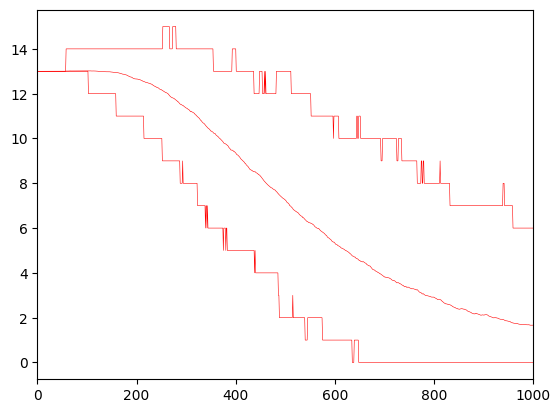

In [51]:
plt.plot(np.mean(simulation_run.votes_record, axis=0)[:decay_steps], c="red", linewidth=0.4, label="normal")
plt.plot(np.sort(simulation_run.votes_record, axis=0)[int(n_tested_patterns*0.01), :decay_steps], c="red", linewidth=0.4)
plt.plot(np.sort(simulation_run.votes_record, axis=0)[int(n_tested_patterns*0.99), :decay_steps], c="red", linewidth=0.4)
plt.xlim(0, 1000)

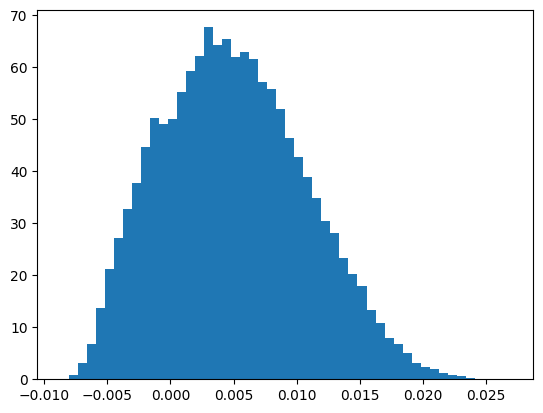

In [52]:
plt.hist(np.array(neuron.w.reshape((-1, ))), bins=50, density=True);

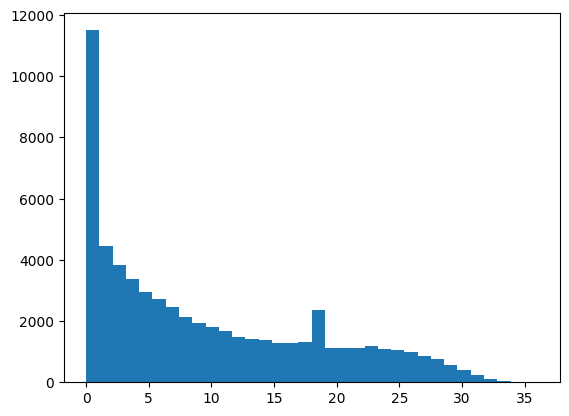

In [53]:
plt.hist(np.array(neuron.latent_var.reshape((-1, ))), bins=34);

In [54]:
votes_mean = np.mean(simulation_run.votes_record, axis=0)[:decay_steps]
votes_lower99 = np.sort(simulation_run.votes_record, axis=0)[int(n_tested_patterns*0.01), :decay_steps]
votes_upper99 = np.sort(simulation_run.votes_record, axis=0)[int(n_tested_patterns*0.99), :decay_steps]
n0 = np.mean(votes_upper99[-4000:])
print("n0 =", n0)
n0 = np.ceil(n0)
false_negative_prob = np.mean(simulation_run.votes_record <= n0, axis=0)[:decay_steps]

n0 = 3.99675


(0.0, 0.06)

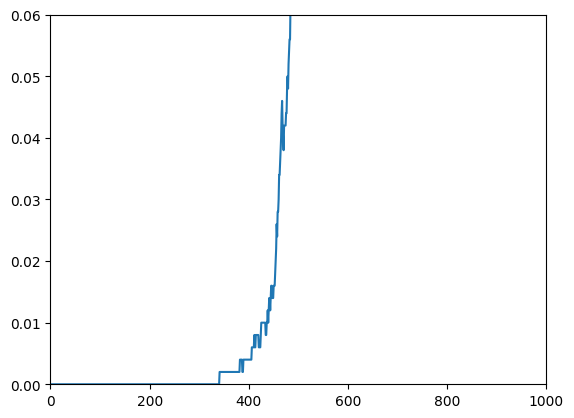

In [55]:
plt.plot(false_negative_prob)
plt.xlim(0, 1000)
plt.ylim(0, 0.06)

In [56]:
ns=200
nd=300
bias = 0.17
ndR = 13
k = 0.05
la = 0.526754
fA = 0.1
beta1 = 0.95
beta2 = 0.1
beta3 = 0.01
beta4 = 5.

decay_steps = 10000
n_tested_patterns = 500
initial_steps = 20000

seed = 123456
rng = np.random.default_rng(seed)

# neuron2 = Neuron6(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, gamma=0.9, seed=rng.integers(100000))
# neuron2 = Neuron3(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, seed=rng.integers(100000))
# neuron2 = Neuron7(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, beta=beta1, seed=rng.integers(100000))
# neuron2 = Neuron8(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, w_len=1., beta1=beta1, beta2=beta2, seed=rng.integers(100000))
neuron2 = Neuron9(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=k, ndR=ndR, fA=fA, w_len=1., beta1=beta1, beta2=beta2, beta3=beta3, beta4=beta4, seed=rng.integers(100000))

xs_gen2 = Xs_Generator2(fA=fA, ns=ns, normalizedQ=True, seed=rng.integers(100000))
# xs_gen = Xs_Generator1(normalized_len=np.sqrt(ns), seed=rng.integers(100000))

simulation_run2 = Simulation_Run2(neuron2, xs_gen2, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))

In [57]:
simulation_run2.run()

100%|██████████| 10500/10500 [00:25<00:00, 409.61it/s]


(0.0, 1000.0)

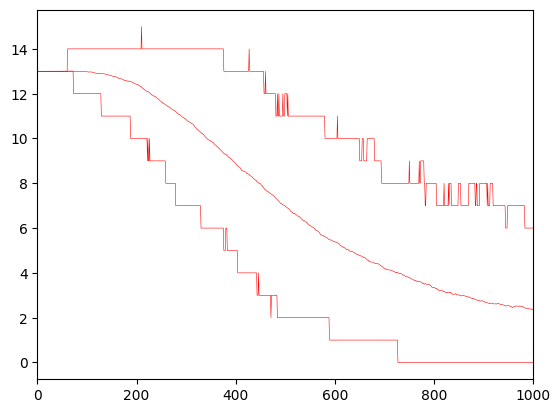

In [58]:
plt.plot(np.mean(simulation_run2.votes_record, axis=0)[:decay_steps], c="red", linewidth=0.4, label="normal")
plt.plot(np.sort(simulation_run2.votes_record, axis=0)[int(n_tested_patterns*0.01), :decay_steps], c="red", linewidth=0.4)
plt.plot(np.sort(simulation_run2.votes_record, axis=0)[int(n_tested_patterns*0.99), :decay_steps], c="red", linewidth=0.4)
plt.xlim(0, 1000)

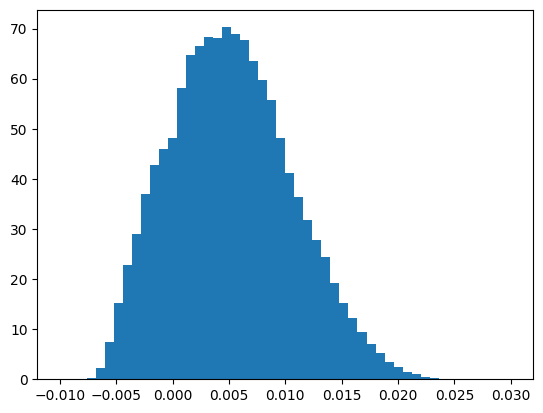

In [59]:
plt.hist(np.array(neuron2.w.reshape((-1, ))), bins=50, density=True, range=(-0.01, 0.03));

0.0


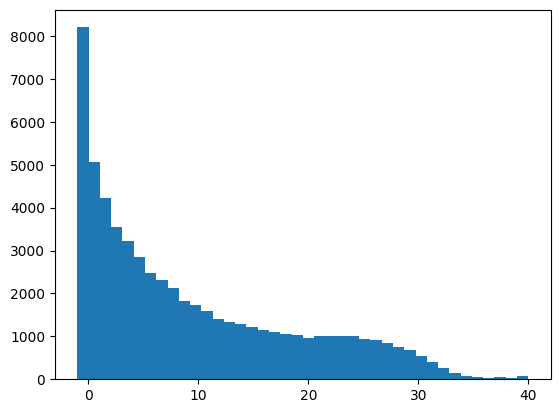

In [67]:
plt.hist(np.array(neuron2.latent_var.reshape((-1, ))), bins=40, range=(-1, 40));
# plt.hist(np.array(neuron2.latent_var.reshape((-1, ))), bins=40);
# print(np.min(neuron2.latent_var.reshape((-1, ))))

In [61]:
votes_mean2 = np.mean(simulation_run2.votes_record, axis=0)[:decay_steps]
votes_lower992 = np.sort(simulation_run2.votes_record, axis=0)[int(n_tested_patterns*0.01), :decay_steps]
votes_upper992 = np.sort(simulation_run2.votes_record, axis=0)[int(n_tested_patterns*0.99), :decay_steps]
n02 = np.mean(votes_upper992[-4000:])
print("n0 =", n02)
n02 = np.ceil(n02)
false_negative_prob2 = np.mean(simulation_run2.votes_record <= n02, axis=0)[:decay_steps]

n0 = 3.927


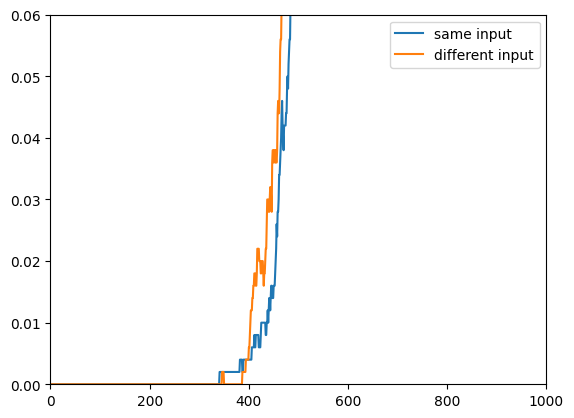

In [62]:
plt.plot(false_negative_prob, label="same input")
plt.plot(false_negative_prob2, label="different input")
plt.xlim(0, 1000)
plt.ylim(0, 0.06)
plt.legend()